## Initialization

The supermarket chain Good Seed would like to explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to people underage. You are asked to conduct that evaluation, so as you set to work, keep the following in mind:

* The shops are equipped with cameras in the checkout area which are triggered when a person is buying alcohol
* Computer vision methods can be used to determine age of a person from a photo
* The task then is to build and evaluate a model for verifying people's age

To start working on the task, you'll have a set of photographs of people with their ages indicated.

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


In [4]:
file_path = '/datasets/faces/final_files/'

In [5]:
# creating image data generator

train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=file_path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [6]:
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=file_path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


## EDA

In [7]:
print('Number of samples in the dataset:', len(labels))

Number of samples in the dataset: 7591


In [8]:
print('There are', labels.duplicated(subset='file_name').sum(), 'duplicated file names')

There are 0 duplicated file names


In [9]:
print('Missing values in the dataset')
print(labels.isnull().sum())

Missing values in the dataset
file_name    0
real_age     0
dtype: int64


In [10]:
labels['under21'] = labels['real_age'] < 21
labels

,file_name,real_age,under21
0,000000.jpg,4,True
1,000001.jpg,18,True
2,000002.jpg,80,False
3,000003.jpg,50,False
4,000004.jpg,17,True
...,...,...,...
7586,007608.jpg,14,True
7587,007609.jpg,37,False
7588,007610.jpg,28,False
7589,007611.jpg,20,True


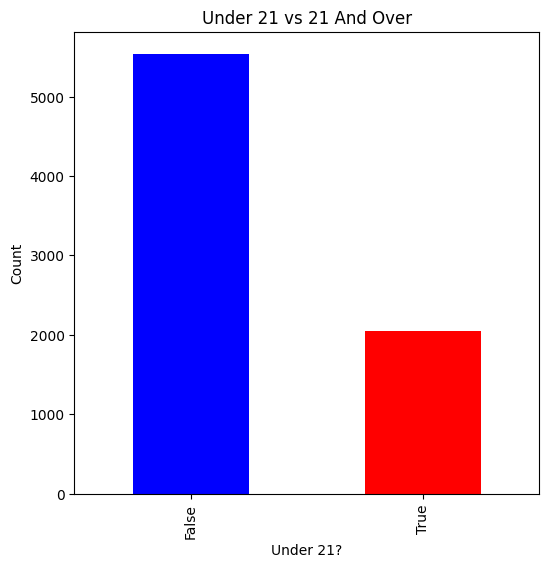

In [11]:
counts21 = labels['under21'].value_counts()

plt.figure(figsize=(6, 6))
counts21.plot(kind='bar', color=['blue', 'red'])
plt.xlabel('Under 21?')
plt.ylabel('Count')
plt.title('Under 21 vs 21 And Over')
plt.show()

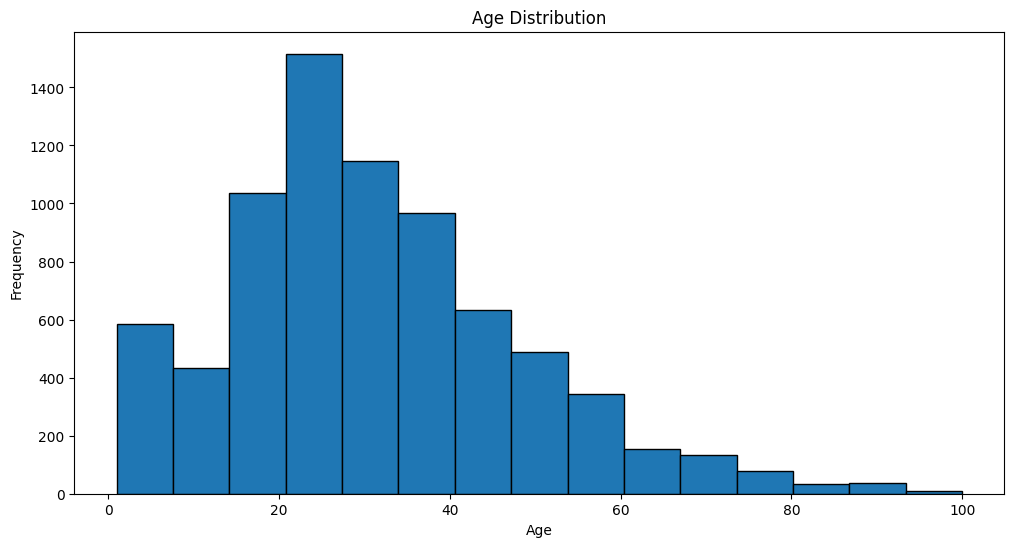

In [12]:
# plotting the age distribution of the image set

plt.figure(figsize=(12,6))
plt.hist(labels['real_age'], bins=15, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

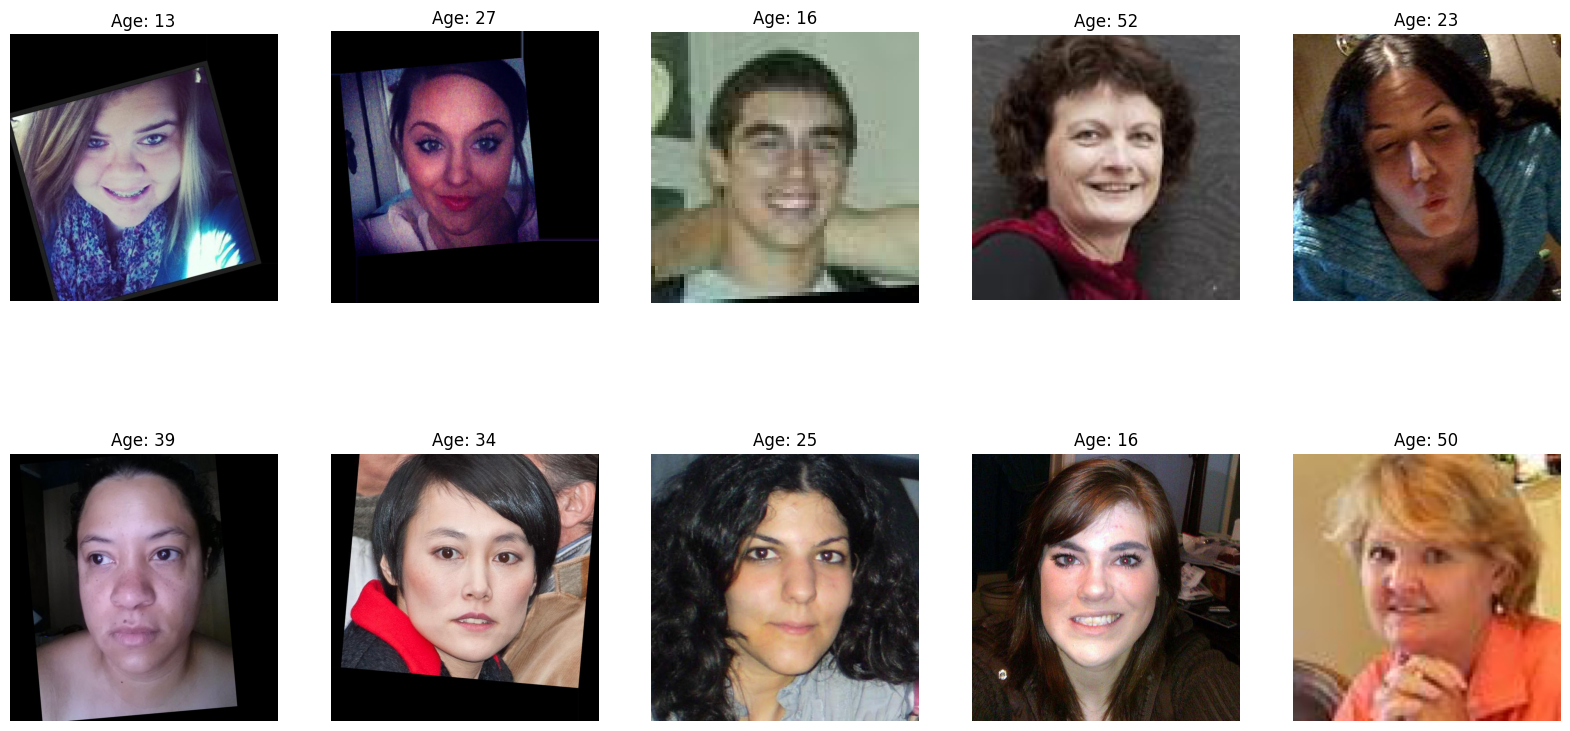

In [13]:
import random

# selecting random samples to display
samples = random.sample(range(len(labels)), 10)

# displaying sampled images
plt.figure(figsize=(20,10))

for i, index in enumerate(samples, 1):
    image_path = file_path + labels.loc[index, 'file_name']
    image = plt.imread(image_path)
    plt.subplot(2, 5, i)
    plt.imshow(image)
    plt.title(f"Age: {labels.loc[index, 'real_age']}")
    plt.axis('off')

plt.show()

### Findings

* There are no missing values or duplicate file names in our data
* The distribution of the age groups seems to favor those ages 20 through 40
* There are over twice as many ages over 21 than there are under 21, so the class of being able to buy alcohol will be well represented

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [14]:
import pandas as pd

import tensorflow as tf


from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [15]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    # place your code here
    
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345
        )

    return train_datagen_flow

In [16]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345
        )
    
    return test_datagen_flow

In [17]:
def create_model(input_shape):
    
    """
    It defines model
    """
    
    backbone = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [18]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
        
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

Validating the `load_train` and `load_test` functions work

In [19]:
print(load_train(file_path))

Found 5694 validated image filenames.


In [20]:
print(load_test(file_path))

Found 1897 validated image filenames.


## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [21]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

Epoch 1/20\
356/356 - 35s - loss: 95.3532 - mae: 7.4339 - val_loss: 124.3362 - val_mae: 8.4921\
Epoch 2/20\
356/356 - 35s - loss: 76.8372 - mae: 6.6707 - val_loss: 127.6357 - val_mae: 8.6035\
Epoch 3/20\
356/356 - 35s - loss: 69.9428 - mae: 6.3992 - val_loss: 91.1531 - val_mae: 7.4454\
Epoch 4/20\
356/356 - 35s - loss: 64.4249 - mae: 6.1407 - val_loss: 124.0287 - val_mae: 8.3481\
Epoch 5/20\
356/356 - 35s - loss: 52.8486 - mae: 5.5913 - val_loss: 109.1004 - val_mae: 8.2192\
Epoch 6/20\
356/356 - 35s - loss: 46.3094 - mae: 5.2223 - val_loss: 85.1038 - val_mae: 7.0332\
Epoch 7/20\
356/356 - 35s - loss: 38.2617 - mae: 4.7951 - val_loss: 92.0900 - val_mae: 7.3359\
Epoch 8/20\
356/356 - 35s - loss: 37.4804 - mae: 4.7402 - val_loss: 80.0016 - val_mae: 6.7239\
Epoch 9/20\
356/356 - 35s - loss: 33.5237 - mae: 4.4271 - val_loss: 83.2579 - val_mae: 6.8529\
Epoch 10/20\
356/356 - 35s - loss: 28.5170 - mae: 4.1411 - val_loss: 83.5056 - val_mae: 6.9629\
Epoch 11/20\
356/356 - 35s - loss: 27.0142 - mae: 3.9700 - val_loss: 92.1290 - val_mae: 7.1866\
Epoch 12/20\
356/356 - 35s - loss: 27.4564 - mae: 4.0428 - val_loss: 185.6307 - val_mae: 11.4591\
Epoch 13/20\
356/356 - 35s - loss: 23.7961 - mae: 3.7407 - val_loss: 92.3429 - val_mae: 7.2467\
Epoch 14/20\
356/356 - 35s - loss: 24.6167 - mae: 3.8116 - val_loss: 92.4542 - val_mae: 7.1401\
Epoch 15/20\
356/356 - 35s - loss: 22.2604 - mae: 3.6746 - val_loss: 82.5822 - val_mae: 6.7841\
Epoch 16/20\
356/356 - 35s - loss: 20.1899 - mae: 3.4430 - val_loss: 86.3830 - val_mae: 6.8304\
Epoch 17/20\
356/356 - 35s - loss: 17.3425 - mae: 3.2205 - val_loss: 78.4369 - val_mae: 6.6419\
Epoch 18/20\
356/356 - 35s - loss: 16.5249 - mae: 3.1295 - val_loss: 81.7731 - val_mae: 6.7226\
Epoch 19/20\
356/356 - 35s - loss: 16.6140 - mae: 3.1421 - val_loss: 80.9727 - val_mae: 6.9908\
Epoch 20/20\
356/356 - 35s - loss: 17.0187 - mae: 3.1785 - val_loss: 93.4115 - val_mae: 7.6512

## Conclusions

After looking at the results of the model, here is what I can conclude:

* Across 20 epochs, the model seems to converge nicely on the training data, getting it's mean absolute error down to 3.1
* The model is possibly suffering from overfitting, however, as the test MAE is over double the training MAE
* Perhaps we need more data, or a more complex model to have better performance on unseen data
* In terms of the outcomes of this model in the real world, It will likely perform okay on customers who are already significantly older than 21, since it's expected MAE is around 7-8 years.
  * But it could be risky to rely on just the prediction on anyone who is between the ages of 18-28 or so, because of that MAE of around 7-8.

# Checklist

- [x]  Notebook was opened
- [x]  The code is error free
- [x]  The cells with code have been arranged by order of execution
- [x]  The exploratory data analysis has been performed
- [x]  The results of the exploratory data analysis are presented in the final notebook
- [x]  The model's MAE score is not higher than 8
- [x]  The model training code has been copied to the final notebook
- [x]  The model training output has been copied to the final notebook
- [x]  The findings have been provided based on the results of the model training